# Check GPU

It is recommended to run this notebook with GPU support. If you have an Nvidea graphics card and drivers installed, the following block of code should show the details of the installed GPU.

In [1]:
!nvidia-smi

Thu Feb 01 00:30:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 446.14       Driver Version: 446.14       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# Import Packages

In [2]:
# Import packages

import torch
import numpy as np

import os
import glob
import joblib
import random
import matplotlib.pyplot as plt

In [3]:
# Import model architectures and data structures
os.chdir(r'E:\unt\spring_2024\radio\Loop_model')

from data_utils import MapDataset

from models.autoencoders import BaselineAutoencoder
from models.autoencoders import SkipAutoencoder, SkipResidualAutoencoder, SkipMaskAutoencoder, SkipMaskMapAutoencoder
from models.autoencoders import SkipMapAutoencoder, SkipMapMaskAutoencoder, SkipInputAutoencoder
from models.autoencoders import DualMaskAutoencoder, DualMaskMapAutoencoder, DualMapAutoencoder, DualMaskMapAutoencoder, DualInputAutoencoder

# Set Hyperparameters

In [4]:
# Set random seed, define device

seed = 3
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Set batch size, learning rate, and number of epochs
train_batch_size = 256
num_epochs = 1
lr = 5e-4

# Manually set values for buildings, unsampled locations, and sampled locations in the environment mask. 
# For the models in the PIMRC paper, these are set to "None", meaning they keep the default values of -1, 0, and 1 respectively.
building_value = None
unsampled_value = None
sampled_value = None

Specify the model architecture by selecting one of the classes imported above from models.autoencoders. Different hyperparameters can be set for each model, but the default values match the ones used in our experiments.

In [6]:
# Specify model type. Below we give an example for one of the models from the paper.
model = SkipResidualAutoencoder().to(device)
model_name = 'Skip_Residual.pth'

Before running the following code block, create a folder to save the trained models, then enter the path to that folder in the variable `model_folder`.

In [7]:
# Set where to save the trained model weights
model_folder = os.getcwd()+"\\models"
assert os.path.isdir(model_folder)

In [8]:
# Identify paths to training data and data scaler
train_data_folder = 'E:\\unt\\spring_2024\\radio\\dataset\\generated_maps\\02_01__04h_23m\\test'
scaler_path = 'scalers/minmax_scaler_zero_min134.joblib'

assert os.path.isdir(train_data_folder)
assert os.path.exists(scaler_path)

In [9]:
#@title Load Training data into DataLoader
train_pickle_path = os.path.join(train_data_folder, '*.pickle')
train_pickles = glob.glob(train_pickle_path)

with open(scaler_path, 'rb') as f:
  scaler = joblib.load(f)

train_ds = MapDataset(train_pickles, scaler=scaler, building_value=building_value, sampled_value=sampled_value)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=train_batch_size, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

C:\Users\jashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
def plot_loss(total_loss):
    
    # Generate x-axis values (epochs or iterations)
    epochs = range(1, len(total_loss) + 1)
    plt.figure(figsize=(8, 6))
    
    # Plot the losses
    plt.plot(epochs, total_loss, '-o')
    
    # Set plot labels
    plt.xlabel('Epochs')
    plt.ylabel('MSE (dB)')
    
    # Set plot title
    plt.title('Loss over Epochs')
    
    # Display the plot
    plt.show()

# Train Model

In [11]:
final_loss,loss_history=model.fit(train_dl, optimizer, epochs=2, loss='mse')

0.10109467804431915, [1,     1] losssssss: 0.10109467804431915
1.3551042079925537, [1,     2] losssssss: 0.7280994430184364
0.0712185949087143, [1,     3] losssssss: 0.5091391603151957
0.17119939625263214, [1,     4] losssssss: 0.4246542192995548
0.1903609037399292, [1,     5] losssssss: 0.3777955561876297
0.1928204745054245, [1,     6] losssssss: 0.34696637590726215
0.1819685995578766, [1,     7] losssssss: 0.3233952650002071
0.16232016682624817, [1,     8] losssssss: 0.3032608777284622
0.13139109313488007, [1,     9] losssssss: 0.284164234995842
0.07850397378206253, [1,    10] losssssss: 0.26359820887446406
0.06345580518245697, [1,    11] losssssss: 0.24540344490246338
0.1025160551071167, [1,    12] losssssss: 0.23349616241951784
0.07975087314844131, [1,    13] losssssss: 0.2216696017063581
0.04726050794124603, [1,    14] losssssss: 0.20921180929456437
0.04555388167500496, [1,    15] losssssss: 0.19830128078659376
0.05430973321199417, [1,    16] losssssss: 0.18930180906318128
0.05834

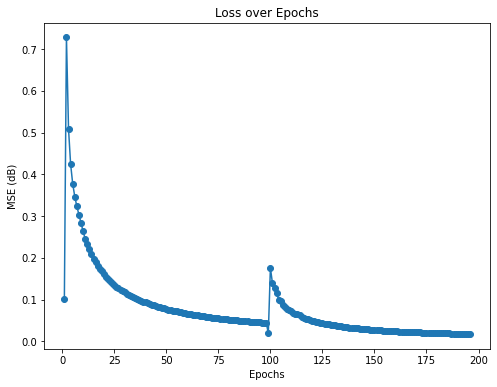

In [14]:
plot_loss(loss_history)

# Save Model

In [15]:
model.save_model(os.path.join(model_folder, "loop_model"))